# Preliminary operations

In [1]:
#@title Drive mount

from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/Assignment/OriginalDataset

Mounted at /content/gdrive
/content/gdrive/MyDrive/Assignment/OriginalDataset


In [2]:
#@title Main libraries
import pandas as pd
import numpy as np

import os
import random

from sklearn.utils import  compute_class_weight

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers

In [3]:
#@title Reproducibility
# Setting a seed for reproducibility
seed = 90 
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print("The seed is: " + str(seed))

The seed is: 90


# Denoising comparison

In [ ]:
filters = { 'name': 'Set of filters',
        'predictions': np.load('/content/gdrive/MyDrive/AI project/models/5.2. predictions_HMP_EffNet_model_30_01.npy'), 
        'target': np.load('/content/gdrive/MyDrive/AI project/models/target_hmp.npy').astype(int)}

DAE = { 'name': 'DAE',
        'predictions': np.load('/content/gdrive/MyDrive/AI project/models/5.3. predictions_AP_EffNet_model_31_01.npy'), 
        'target': np.load('/content/gdrive/MyDrive/AI project/models/target_ap.npy').astype(int)}

FCDN = { 'name': 'FCDN',
        'predictions': np.load('/content/gdrive/MyDrive/AI project/models/5.4. predictions_FCDNP_EffNet_model_01_02.npy'), 
        'target': np.load('/content/gdrive/MyDrive/AI project/models/target_fcdnp.npy').astype(int)}

all = [filters, DAE, FCDN]

legend = {'Normal': 0, 'Pneumonia': 1, 'Tubercolosis': 2}

In [ ]:
Metrics = pd.DataFrame()

for m in all:
  y_pred = np.argmax(m['predictions'], axis=-1)
  y_true = m['target']

  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average=None)
  recall = recall_score(y_true, y_pred, average=None)
  f1 = 2*(precision*recall)/(precision+recall)

  line = {'name': m['name'],
          'Total Accuracy': round(accuracy,2),
          'F1 score (N, P, T)': np.round(f1,2)}
  
  Metrics = Metrics.append(line, ignore_index=True)

Metrics

,name,Total Accuracy,"F1 score (N, P, T)"
0,Set of filters,0.97,"[0.97, 0.98, 0.91]"
1,DAE,0.96,"[0.96, 0.97, 0.87]"
2,FCDN,0.96,"[0.97, 0.96, 0.89]"


# Models

In [6]:
cnn = { 'name': 'CNN',
        'predictions': np.load('/content/gdrive/MyDrive/AI project/models/1. predictions_FromScratchWithClassWeights.npy')}

resnet = { 'name': 'Resnet',
        'predictions': np.load('/content/gdrive/MyDrive/AI project/models/2.1. predictions_ResNet_model_03012023.npy')} 

effnetb0 = { 'name': 'EffNet_B0',
        'predictions': np.load('/content/gdrive/MyDrive/AI project/models/5.1. predictions_EffNetB0_model_0401.npy')}

effnetvs2 = { 'name': 'EffNet_VS2',
        'predictions': np.load('/content/gdrive/MyDrive/AI project/models/4. predictions_effnet03012023.npy')}


ensemble = { 'name': 'Ensemble',
        'predictions': np.load('/content/gdrive/MyDrive/AI project/models/predictions_Ensemble.npy')}
    

In [11]:
models = [cnn , resnet, effnetb0, effnetvs2]

In [8]:
target = np.load('/content/gdrive/MyDrive/AI project/models/target_vector.npy')

In [9]:
legend = {'Normal': 0, 'Pneumonia': 1, 'Tubercolosis': 2}

# Metrics 

In [12]:
Metrics = pd.DataFrame()

for m in models:
  y_pred = np.argmax(m['predictions'], axis=-1)
  y_true = target.astype(int)

  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average=None)
  recall = recall_score(y_true, y_pred, average=None)
  f1 = 2*(precision*recall)/(precision+recall)

  line = {'name': m['name'],
          'Total Accuracy': round(accuracy,2),
          'Recall (N, P, T)': np.round(recall,2),
          'Precision (N, P, T)': np.round(precision,2),
          'F1 score (N, P, T)': np.round(f1,2)}
  
  Metrics = Metrics.append(line, ignore_index=True)

Metrics
  

,name,Total Accuracy,"Recall (N, P, T)","Precision (N, P, T)","F1 score (N, P, T)"
0,CNN,0.93,"[0.92, 0.98, 0.92]","[0.97, 0.97, 0.73]","[0.95, 0.97, 0.81]"
1,Resnet,0.95,"[0.97, 0.96, 0.82]","[0.95, 0.97, 0.89]","[0.96, 0.97, 0.85]"
2,EffNet_B0,0.96,"[0.95, 0.97, 0.92]","[0.97, 0.97, 0.83]","[0.96, 0.97, 0.88]"
3,EffNet_VS2,0.95,"[0.97, 0.95, 0.82]","[0.95, 0.98, 0.86]","[0.96, 0.97, 0.84]"


# ROC curves


In [ ]:
def get_roc(models, target):
  
  legend = {'Normal': 0, 'Pneumonia': 1, 'Tubercolosis': 2}
  fig, axs = plt.subplots(1,3, figsize=(80,20))
  AUC = pd.DataFrame()

  for m in models:
    pred = m['predictions']
    auc = np.zeros(3)

    for c, i in legend.items():
      probs = pred[:,i]
      y = (target==i).astype(int)

      # calculate roc curve
      fpr, tpr, thresholds = roc_curve(y, probs)

      # calculate AUC
      auc[i] = roc_auc_score(y, probs)

      axs[i].plot(fpr, tpr, label= m['name'])

      # axis labels
      axs[i].set_xlabel('False Positive Rate')
      axs[i].set_ylabel('True Positive Rate')
      axs[i].set_title(c)

      # show the legend
      #axs[i].legend()
    
    m['auc'] = auc
    line = {'name': m['name'],
            'Normal': auc[0],
            'Pneumonia': auc[1],
            'Tubercolosis': auc[2]}

    AUC = AUC.append(line, ignore_index=True)
  

  return models, AUC

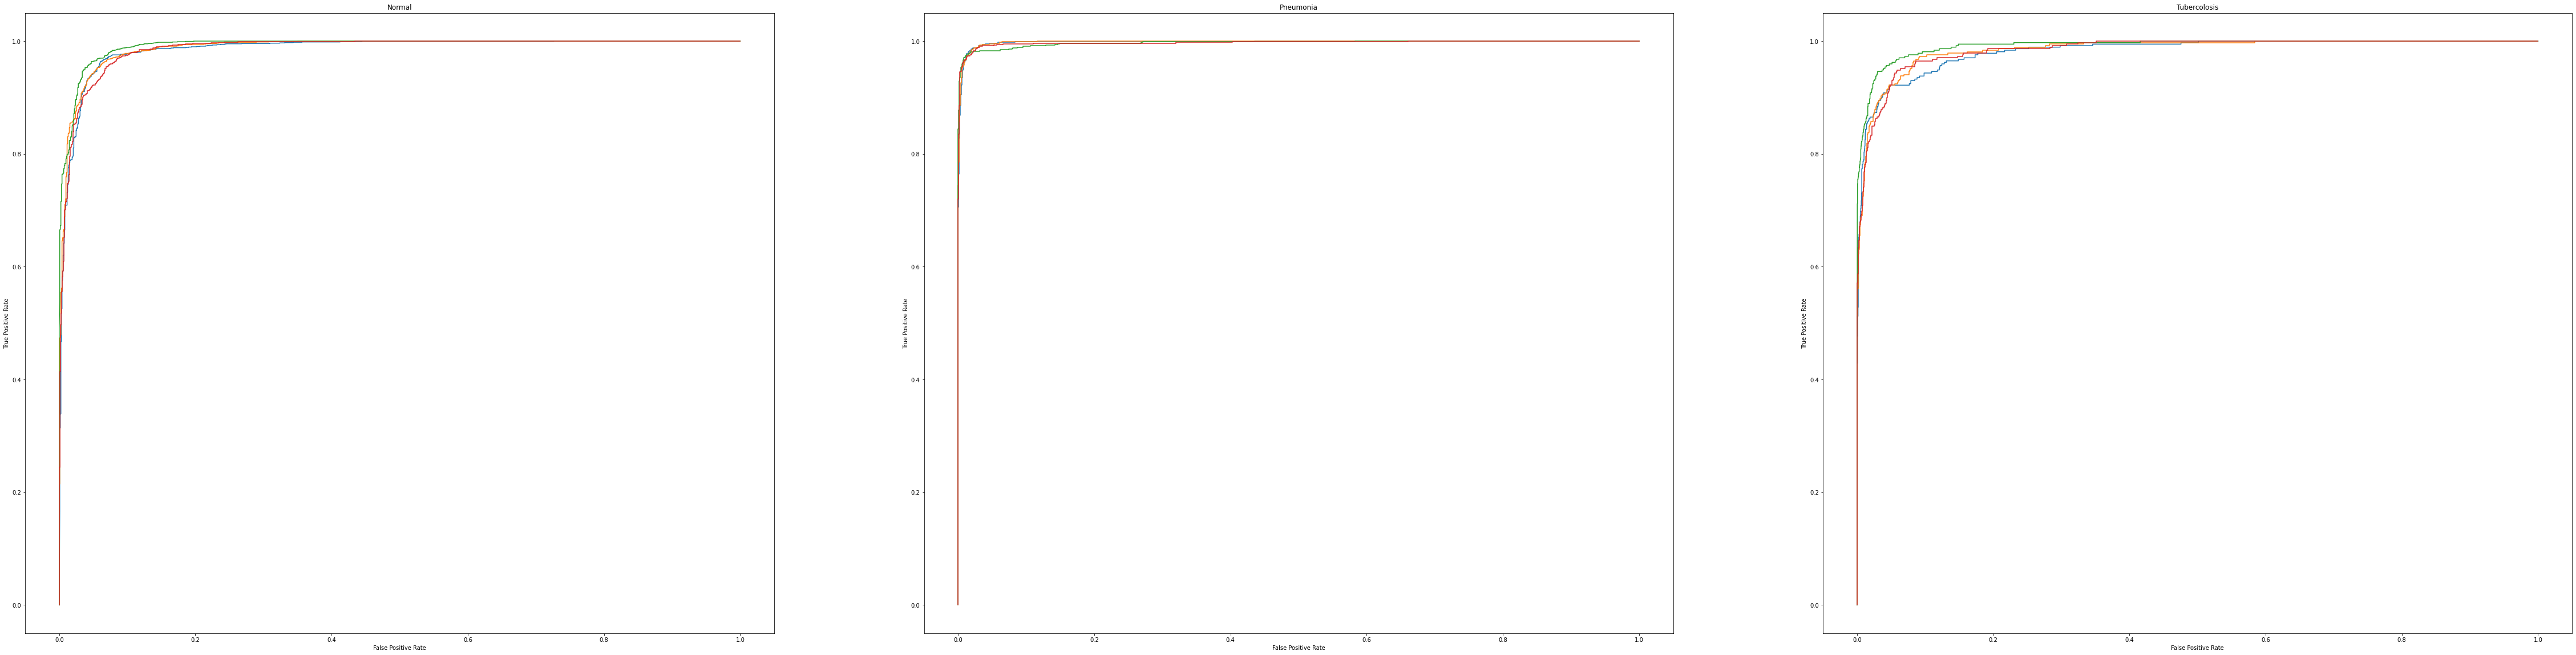

In [ ]:
models, AUC = get_roc(models, target)

In [ ]:
AUC

,name,Normal,Pneumonia,Tubercolosis
0,CNN_weightedloss,0.985570,0.997957,0.982246
1,Resnet_SEblocks,0.988093,0.998444,0.984873
2,EffNet_B0,0.991960,0.996805,0.991766
3,EffNet_VS2,0.986314,0.997081,0.984515
4,Ensemble,0.993646,0.998978,0.992865


In [ ]:
ens_models = ['EffNet_B0','Resnet_SEblocks']